# 1. Image Classification

In [4]:
import numpy as np

# Import MNIST dataset
data = np.loadtxt(open('datasets/mnist/mnist_train_small.csv', 'rb'), delimiter=',')
# Shape of the data matrix
print(data.shape)

(20000, 785)


In [5]:
# Extract labels and remove from data
labels = data[:, 0]
data = data[:, 1:]

print("Label Shape:", labels.shape)
print("Data Shape:", data.shape)

Label Shape: (20000,)
Data Shape: (20000, 784)


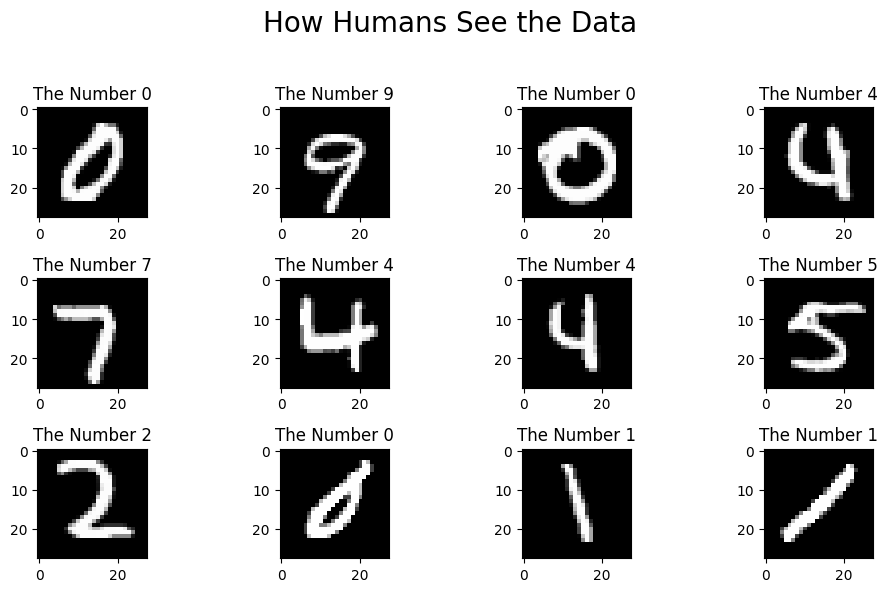

In [9]:
import matplotlib.pyplot as plt

# Show a few random digits
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
  # Pick a random image
  random_image_idx = np.random.randint(0, high=data.shape[0])

  # Create the image
  random_image = np.reshape(data[random_image_idx, :], (28, 28))
  ax.imshow(random_image, cmap='gray')

  # Title
  ax.set_title('The Number %i' % labels[random_image_idx])

plt.suptitle('How Humans See the Data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

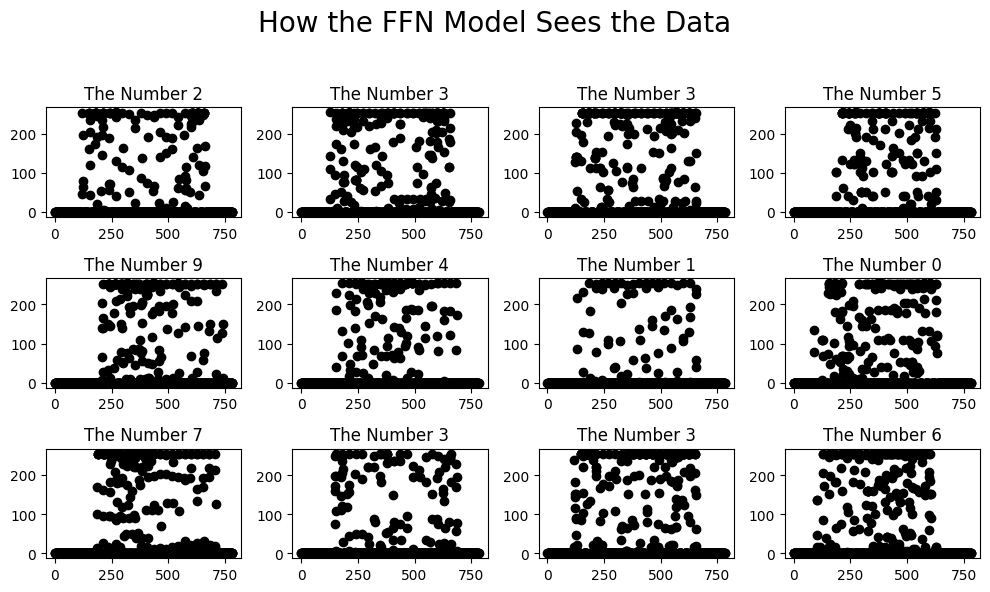

In [14]:
# Show a few random digits
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
  # Pick a random image
  random_image_idx = np.random.randint(0, high=data.shape[0])

  # create the image
  ax.plot(data[random_image_idx, :], 'ko')
  # print(data[random_image_idx].shape)
  # (784,)

  # Title
  ax.set_title('The Number %i' % labels[random_image_idx])

plt.suptitle('How the FFN Model Sees the Data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

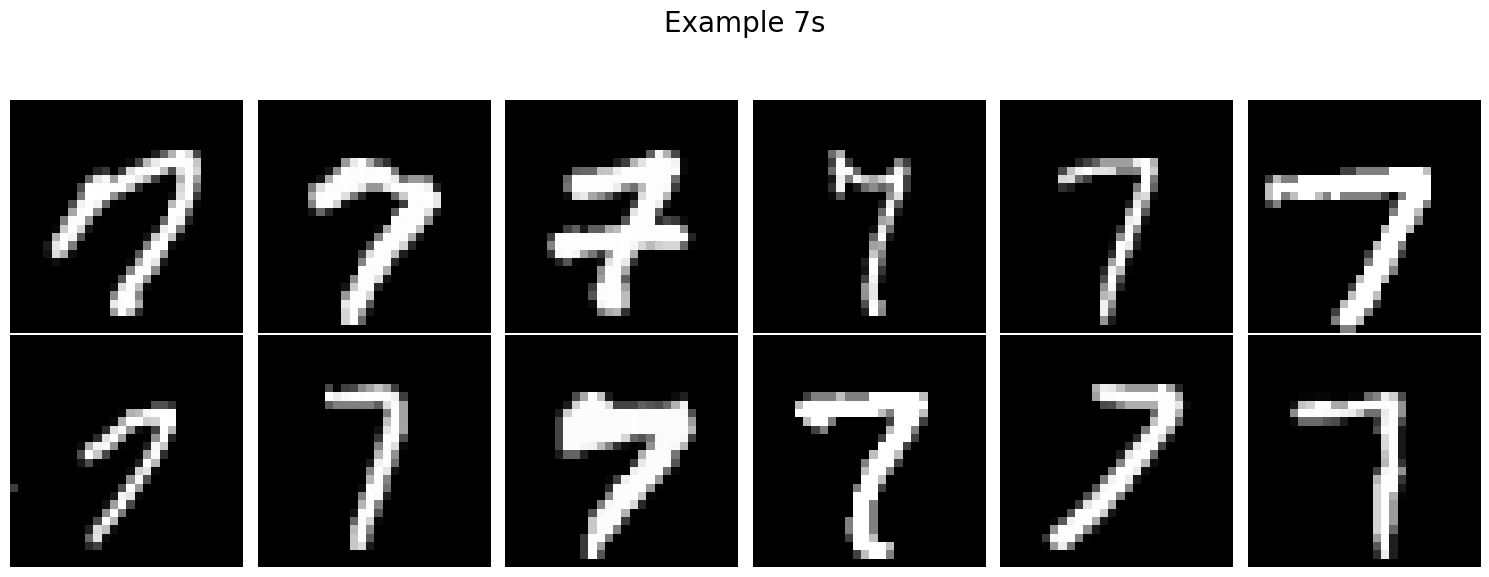

In [19]:
# Find indices of all the 7's in the dataset
images_7 = np.where(labels==7)[0]

# Draw the first 12
fig, axs = plt.subplots(2, 6, figsize=(15, 6))

for idx, ax in enumerate(axs.flatten()):
    image_7 = np.reshape(data[images_7[idx], :], (28, 28))
    ax.imshow(image_7, cmap='gray')
    ax.axis('off')

plt.suptitle("Example 7s", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

(2126, 784)


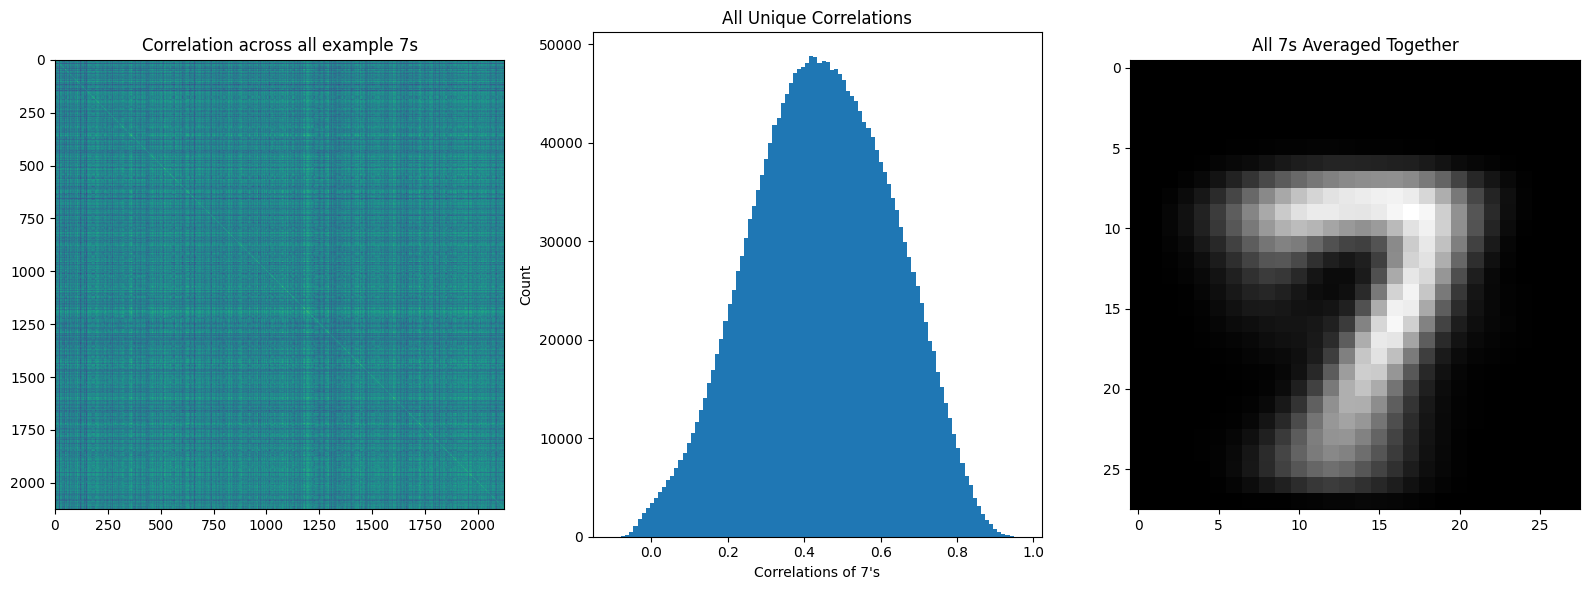

In [22]:
# How many 7's are there?
print(data[images_7, :].shape)

# Let's see how they relate to each other by computing spatial correlations
C = np.corrcoef(data[images_7, :])

# Visualize
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
ax[0].imshow(C, vmin=0, vmax=1)
ax[0].set_title("Correlation across all Example 7s")

# Extract the unique correlations and show as a scatterplot
unique_correlations = np.triu(C, k=1).flatten()
ax[1].hist(unique_correlations[unique_correlations != 0], bins=100)
ax[1].set_title('All Unique Correlations')
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

# Show all 7's together
mean_images_7 = np.reshape(np.mean(data[images_7, :], axis=0), (28, 28))
ax[2].imshow(mean_images_7, cmap='gray')
ax[2].set_title("All 7s Averaged Together")

plt.tight_layout()
plt.show()

In [ ]:
# [2]
# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 60
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

predictions

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

In [ ]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 10

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s' 
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

In [ ]:
# [3]
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
### exploring the "innards" of the model

# create a temp model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
print('Summary of model:')
print(net)
print(' ')

# # explore one of the layers
# print('Summary of input layer:')
# print( vars(net.input) )
# print(' ')

# # check out the matrix of weights
# print('Input layer weights:')
# print( net.input.weight.shape )
# print( net.input.weight )
# print(' ')

# # finally, extract the weights and make a histogram
# w = net.input.weight.detach().flatten()
# plt.hist(w,40)
# plt.xlabel('Weight value')
# plt.ylabel('Count')
# plt.title('Distribution of initialized input-layer weights')
# plt.show()

In [ ]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])
  
  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy




# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx = np.zeros((numepochs,100))
  histy = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)
  
    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy

In [ ]:
trainAcc,testAcc,losses,net,histx,histy = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()

In [ ]:
# [4] Scrambled MNIST
# randomly scramble the data,
# preserving the re-ordering for each image
eggs = np.random.permutation(data.shape[1])
scrambled = dataNorm[:,eggs]


# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(scrambled[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('The scrambled data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( scrambled ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# [5] Shifted
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)


# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [ ]:
# now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = test_loader.dataset.tensors[0][i,:]
  
  # reshape and roll by max. 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img.reshape(28,28) ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)


# Note: now run the previous cell again to confirm the shifting

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# 2. Convolution
## 2-1. Convolution in SciPy

In [ ]:
# image
imgN = 20
image = np.random.randn(imgN,imgN)

# convolution kernel
kernelN = 7
Y,X = np.meshgrid(np.linspace(-3,3,kernelN),np.linspace(-3,3,kernelN))
kernel = np.exp( -(X**2+Y**2)/7 )


# let's see what they look like
fig,ax = plt.subplots(1,2,figsize=(8,6))
ax[0].imshow(image)
ax[0].set_title('Image')

ax[1].imshow(kernel)
ax[1].set_title('Convolution kernel')

plt.show()

In [ ]:
# now for the convolution
convoutput = np.zeros((imgN,imgN))
halfKr = kernelN//2

for rowi in range(halfKr,imgN-halfKr):
  for coli in range(halfKr,imgN-halfKr):

    # cut out a piece of the image
    pieceOfImg = image[rowi-halfKr:rowi+halfKr+1,:]      # get the rows
    pieceOfImg = pieceOfImg[:,coli-halfKr:coli+halfKr+1] # extract the columns

    # dot product: element-wise multiply and sum (and flip the kernel for "real convolution")
    dotprod = np.sum( pieceOfImg*kernel[::-1,::-1] )

    # store the result for this pixel
    convoutput[rowi,coli] = dotprod

In [ ]:
# using scipy
convoutput2 = convolve2d(image,kernel,mode='valid')

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].imshow(image)
ax[0,0].set_title('Image')

ax[0,1].imshow(kernel)
ax[0,1].set_title('Convolution kernel')

ax[1,0].imshow(convoutput)
ax[1,0].set_title('Manual convolution')

ax[1,1].imshow(convoutput2)
ax[1,1].set_title("Scipy's convolution")

plt.show()

In [ ]:
# [] Convolution with different kernels in a real image
# read a pic from the web
bathtub = imread('https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg')

# check the size
print(bathtub.shape)

# let's see what the famous Bathtub Museum looks like
fig = plt.figure(figsize=(10,6))
plt.imshow(bathtub);

# transform image to 2D for convenience (not necessary for convolution!)
bathtub = np.mean(bathtub,axis=2)
bathtub = bathtub/np.max(bathtub)

# check the size again
print(bathtub.shape)

In [ ]:
# hand-craft two convolution kernels

# vertical kernel
VK = np.array([ [1,0,-1],
                [1,0,-1],
                [1,0,-1] ])

# horizontal kernel
HK = np.array([ [ 1, 1, 1],
                [ 0, 0, 0],
                [-1,-1,-1] ])

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
convres = convolve2d(bathtub,VK,mode='same')
ax[1,0].imshow(convres,cmap='gray',vmin=0,vmax=.01)

convres = convolve2d(bathtub,HK,mode='same')
ax[1,1].imshow(convres,cmap='gray',vmin=0,vmax=.01)

plt.show()

In [ ]:
# [3] PyTorch
# first, translate everything into a tensor
import torch
import torch.nn.functional as F

VK_t = torch.tensor(VK).view(1,1,3,3).double()
HK_t = torch.tensor(HK).view(1,1,3,3).double()
bathtub_t = torch.tensor(bathtub).view(1,1,bathtub.shape[0],bathtub.shape[1])

print(VK_t.shape)
print(bathtub_t.shape)

In [ ]:
C = F.conv2d(bathtub_t,VK_t)
print(C.shape)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
convres = F.conv2d(bathtub_t,VK_t)
img = torch.squeeze(convres.detach())
ax[1,0].imshow(img,cmap='gray',vmin=0,vmax=.01)

convres = F.conv2d(bathtub_t,HK_t)
img = torch.squeeze(convres.detach())
ax[1,1].imshow(img,cmap='gray',vmin=0,vmax=.01)

plt.show()

## 2-2. Convolution in PyTorch

In [ ]:
# create a conv2d class instance with parameters

# parameters
inChans  = 3 # RGB
outChans = 15
krnSize  = 5 # should be an odd number
stride   = 1
padding  = 0

# create the instance (cf nn.Linear)
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# let's have a look at it
print(c)
print(' ')

# check out its weight tensor; what are the dimensions?
print( 'Size of weights: ' + str(c.weight.shape) )
print( 'Size of bias: ' + str(c.bias.shape) )

In [ ]:
# What do these kernels look like?

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[i,0,:,:]).detach(),cmap='Purples')
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# size of the image (N, RGB, height, width)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

In [ ]:
# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

In [ ]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):

  # extract this "layer" of the convolution result
  I = torch.squeeze(convRes[0,i,:,:]).detach()

  # and visualize it
  ax.imshow(I,cmap='Purples')
  ax.set_title('Conv. w/ filter %s'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

## 2-3. Transpose Convolution

In [ ]:
# create a ConvTranspose2d class instance with parameters

# parameters
inChans  = 3 # RGB
outChans = 15
krnSize  = 5 # should be an odd number
stride   = 1
padding  = 0

# create the instance
c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# let's have a look at it
print(c)
print(' ')

# check out its weight tensor; what are the dimensions?
print( 'Size of weights: ' + str(c.weight.shape) )
print( 'Size of bias: ' + str(c.bias.shape) )

# tip: Compare the sizes of these weights with those of "forward" convolution (DUDL_convolution_conv2.ipynb)

In [ ]:
# What do these kernels look like?

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[0,i,:,:]).detach(),cmap='Purples')
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# size of the image (N, RGB, width, height)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

In [ ]:
# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

In [ ]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):

  # extract this "layer" of the convolution result
  I = torch.squeeze(convRes[0,i,:,:]).detach()

  # and visualize it
  ax.imshow(I,cmap='Purples')
  ax.set_title('Conv. w/ filter %s'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

# 3. Pooling

In [ ]:
# create a pool class instance with parameters

# parameters
poolSize = 3
stride   = 3

# create the instance
p2 = nn.MaxPool2d(poolSize,stride=3)
p3 = nn.MaxPool3d(poolSize,stride=3)

# let's have a look at them
print(p2)
print(p3)

In [ ]:
# Create image and apply maxpooling

# create a 2D and a 3D image
img2 = torch.randn(1,1,30,30)
img3 = torch.randn(1,3,30,30)


# all combinations of image and maxpool dimensionality
img2Pool2 = p2(img2)
print(f'2D image, 2D maxpool: {img2Pool2.shape}\n' )

# img2Pool3 = p3(img2)
# print(f'2D image, 3D maxpool: {img2Pool3.shape}\n' )

img3Pool2 = p2(img3)
print(f'3D image, 2D maxpool: {img3Pool2.shape}\n' )

img3Pool3 = p3(img3)
print(f'3D image, 3D maxpool: {img3Pool3.shape}\n' )

In [ ]:
littlenet = nn.Sequential(
    
    ## the conv-pool block
    nn.Conv2d(3,10,5,3,2), # convolution layer
    nn.ReLU(),             # activation function
    nn.AvgPool3d(3,3),     # average-pool
    
    ## the FFN block
    nn.Flatten(),          # vectorize to get from image to linear
    nn.Linear(588,1),      # FC linear layer
    nn.Sigmoid()           # output activation
  )

In [ ]:
# test with a bit of data
img = torch.rand(1,3,128,128)
littlenet(img)

# 4. Image Transformation

In [ ]:
# download the CIFAR10 dataset
cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True)

print(cdata)

In [ ]:
# check out the shape of the dataset
print( cdata.data.shape )

# the unique categories
print( cdata.classes )

# .targets is a list of targets converted to ints
print( len(cdata.targets) )

In [ ]:
# inspect a few random images

fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

  # select a random picture
  randidx = np.random.choice(len(cdata.targets))

  # extract that image
  pic = cdata.data[randidx,:,:,:]
  # and its label
  label = cdata.classes[cdata.targets[randidx]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(32*4),
                 T.Grayscale(num_output_channels=1)  ])

# include the transform in the dataset
cdata.transform = Ts

# you can also apply the transforms immediately when loading in the data
# cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True, transform=Ts)


# Important! Adding a transform doesn't change the image data:
print(cdata.data[123,:,:,:].shape)

In [ ]:
# apply the transform

# option 1a: apply the transform "externally" to an image
img1 = Ts( cdata.data[123,:,:,:] )

# option 1b: use the embedded transform
img2 = cdata.transform( cdata.data[123,:,:,:] )

# let's see what we've done!
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(cdata.data[123,:,:,:])
ax[1].imshow(torch.squeeze(img1))
ax[2].imshow(torch.squeeze(img2),cmap='gray')

plt.show()

In [ ]:
# Note about ToTensor() and normalization:
??T.ToTensor()

# 5. Convolutional Neural Networks (CNNs)
## 5-1. Digit Recognition with LeNet-5

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# NEW: reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [ ]:
dataNorm.shape

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height)
train_loader.dataset.tensors[0].shape

In [ ]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

In [ ]:
# count the total number of parameters in the model
summary(net,(1,28,28))

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# [2] Shifted MNIST
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# NEW: reshape to 2D!
dataNorm = dataNorm.reshape(dataNorm.shape[0],1,28,28)

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0,:]
# tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)


# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(torch.squeeze(tmp), cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(torch.squeeze(tmpS), cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [ ]:
# now repeat for all images in the training set

for i in range(train_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = train_loader.dataset.tensors[0][i,:,:]
  
  # reshape and roll by 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  train_loader.dataset.tensors[0][i,:,:] = img


# Note: now run the previous cell again to confirm the shifting

In [ ]:
# now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):
  
  # get the image
  img = test_loader.dataset.tensors[0][i,:,:]
  
  # reshape and roll by 10 pixels
  randroll = np.random.randint(-10,11)
  img = torch.roll( img ,randroll,dims=1 )

  # re-vectorize and put back into the matrix
  test_loader.dataset.tensors[0][i,:,:] = img


# Note: now run the previous cell again to confirm the shifting

In [ ]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)
      
      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):
      
      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      print(f'Vectorize: {x.shape}') if self.print else None
      
      # linear layers
      x = F.relu(self.fc1(x))
      print(f'Layer fc1: {x.shape}') if self.print else None
      x = self.out(x)
      print(f'Layer out: {x.shape}') if self.print else None

      return x
  
  # create the model instance
  net = mnistNet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader))
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [1]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(train_dataset.data.min(), train_dataset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(train_dataset.data.float().mean(), train_dataset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(train_dataset.data.float().mean() / 255, train_dataset.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [3]:
test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True)
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(test_dataset.data.min(), test_dataset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(test_dataset.data.float().mean(), test_dataset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(test_dataset.data.float().mean() / 255, test_dataset.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.791221618652344 
Pixel Values Std: 79.17247009277344
Scaled Mean Pixel Value 0.1325145959854126 
Scaled Pixel Values Std: 0.3104802668094635


In [5]:
import torch

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((32,32)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((32,32)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [8]:
# number of classes
K = len(set(train_dataset.targets.numpy()))
print("number of classes:", K)

number of classes: 10


In [10]:
import torch.nn as nn

# Define the model
class LeNet5(nn.Module):
    def __init__(self, K):
        super(LeNet5, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        # "No zero padding, non-unit strides"
        # https://pytorch.org/docs/stable/nn.html
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, K)
        )
  
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)
        out = self.dense_layers(out)
        return out

model = LeNet5(num_classes).to(device)
model

LeNet5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=120, out_features=84, bias=True)
    (5): ReLU()
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [11]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

total_step = len(train_loader)
total_step

938

In [14]:
# Loop through data
for epoch in range(num_epochs):
  # Training
  for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      # Backward & optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i + 1) % 400 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.0209
Epoch [1/10], Step [800/938], Loss: 0.0154
Epoch [2/10], Step [400/938], Loss: 0.0931
Epoch [2/10], Step [800/938], Loss: 0.0954
Epoch [3/10], Step [400/938], Loss: 0.0467
Epoch [3/10], Step [800/938], Loss: 0.1767
Epoch [4/10], Step [400/938], Loss: 0.0360
Epoch [4/10], Step [800/938], Loss: 0.0144
Epoch [5/10], Step [400/938], Loss: 0.1090
Epoch [5/10], Step [800/938], Loss: 0.0107
Epoch [6/10], Step [400/938], Loss: 0.0227
Epoch [6/10], Step [800/938], Loss: 0.0312
Epoch [7/10], Step [400/938], Loss: 0.0247
Epoch [7/10], Step [800/938], Loss: 0.0248
Epoch [8/10], Step [400/938], Loss: 0.0003
Epoch [8/10], Step [800/938], Loss: 0.0679
Epoch [9/10], Step [400/938], Loss: 0.0147
Epoch [9/10], Step [800/938], Loss: 0.0694
Epoch [10/10], Step [400/938], Loss: 0.0181
Epoch [10/10], Step [800/938], Loss: 0.0727


In [15]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 98.56 %


## 5-2. Gaussian Blurs

In [ ]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

In [ ]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45 
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,1),             # output size: 1
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

In [ ]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [ ]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# look at the filters
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

In [ ]:
fig,axs = plt.subplots(1,6,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

In [ ]:
fig,axs = plt.subplots(4,6,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(4,6))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

In [ ]:
# [2] Feature map activations
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # conv1
      self.conv1 = nn.Conv2d(1,6,3,padding=1)
      # output size: (91+2*1-3)/1 + 1 = 91
      # post-pooling: 91/2 = 45

      # conv2
      self.conv2 = nn.Conv2d(6,4,3,padding=1)
      # output size: (45+2*1-3)/1 + 1 = 45
      # post-pooling: 45/2 = 22

      # fc1
      self.fc1 = nn.Linear(22*22*4,50)

      # fc2 (output)
      self.fc2 = nn.Linear(50,1)
      
    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1act,(2,2))
      
      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2act,(2,2))

      # ANN part
      x = x.reshape(x.shape[0],-1)
      x = F.relu( self.fc1(x) )
      x = self.fc2(x)
      
      return x,conv1act,conv2act
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

# test that the model runs and can compute a loss
X,y = next(iter(train_loader))
yHat,featmap1,featmap2 = net(X)
loss = lossfun(yHat,y)

# check sizes of outputs
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

In [ ]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [ ]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(7,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(6):
    # extract the feature map from this image
    img = featmap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

In [ ]:
# Repeat for feature2 maps

fig,axs = plt.subplots(5,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(4):
    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

In [ ]:
# [4] Spatial correlations across the feature maps
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

In [ ]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

In [ ]:
# [5] Gaussian parameters
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nGauss,1,imgSize,imgSize)
labels = torch.zeros(nGauss,3)

for i in range(nGauss):

  # location and width parameters
  loc = np.max(x)/2 * np.random.randn(2) # center coordinate
  wid = np.random.rand()*10 + 5 # width of Gaussian

  # create the gaussian with random centers
  G  = np.exp( -( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
  G  = G + np.random.randn(imgSize,imgSize)/10
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i,:] = torch.Tensor( [loc[0],loc[1],wid] )

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nGauss)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='top')
  ax.set_title(f'XY=({labels[whichpic,0]:.0f},{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

In [ ]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          
          # conv/pool block 1
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45
          
          # conv/pool block 2
          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          
          # linear decision layer
          nn.Flatten(),                # vectorize conv2 block output
          nn.Linear(22*22*4,50),       # output size: 50
          nn.Linear(50,3),             # output size: 3
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(yHat)
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

In [ ]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 30
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # extract the loss for this test epoch
    testLoss[epochi] = loss.item()

  # end epochs

  # function output
  return trainLoss,testLoss,net

In [ ]:
trainLoss,testLoss,net = function2trainTheModel()

In [ ]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Model loss (final test loss: %.2f)'%testLoss[-1])

plt.show()

In [ ]:
# visualize some images

X,Y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(16,4))

th = np.linspace(0,2*np.pi)

for i,ax in enumerate(axs.flatten()):

  # get the Gaussian and draw it, and draw the white guide-lines
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='lower')
  ax.plot([-4,4],[0,0],'w--')
  ax.plot([0,0],[-4,4],'w--')

  # compute the model's prediction
  cx = yHat[i][0].item() # center X
  cy = yHat[i][1].item() # center Y
  rd = yHat[i][2].item() # radius

  # and draw it
  x = cx + np.cos(th)*np.sqrt(rd)
  y = cy + np.sin(th)*np.sqrt(rd)
  ax.plot(x,y,'b')
  ax.plot(cx,cy,'bo')
  
  # some final plotting niceties
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlim([-4,4])
  ax.set_ylim([-4,4])

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))

paramNames = ['Cx','Cy','rad.']

for i in range(3):
  
  # extract parameters and compute correlation
  yy = Y[:,i].detach()
  yh = yHat[:,i].detach()
  cr = np.corrcoef(yy,yh)[0,1]

  # plot with label
  plt.plot(yy,yh,'o',label=f'{paramNames[i]}, r={cr:.3f}')


plt.legend()
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

## 5-3. Letter Recognition
[EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset)

In [ ]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

In [ ]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

In [ ]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

In [ ]:
cdata.class_to_idx

In [ ]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

In [ ]:
# next issue: do we need to normalize the images?
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('After normalization')
plt.show()

In [ ]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])
  
  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]
  
  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

In [ ]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [ ]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]
  
  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'
  
  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [ ]:
import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()

Try loading the MNIST database in `.npy` format with NumPy. 

In [ ]:
# 
mnist_data = torch.from_numpy(np.load('datasets/mnist_npy/images.npy'))
mnist_labels = torch.from_numpy(np.load('datasets/mnist_npy/labels.npy'))

train_size = int(mnist.shape[0] * 0.7)
test_size = int(mnist.shape[0] * 0.1)

train_data = mnist_data[:train_size]
train_labels = mnist_labels[:train_size]
validate_data = mnist_data[train_size:-test_size]
validate_labels = mnist_labels[train_size:-test_size]
test_data = mnist_data[:-test_size]
test_labels = mnist_labels[:-train_size]
print("Training Data Shape:", train_data.shape)
print("Validation Data Shape:", validate_data.shape)
print("Test Data Shape:", test_data.shape)